In [1]:
import urllib.request
import os, shutil
import csv
import lxml.html
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_folder_name = 'data' # folder to store the images in 
cleanup = True     # delete downloaded images after the numpy data array was created

if not os.path.exists(image_folder_name):
    os.makedirs(image_folder_name)

In [3]:
# download all BOB ROSS images from all seasons of TJOP from http://www.twoinchbrush.com
max_idx = 411 # 

flawed_indices = []

for im in range(max_idx): 
        file_idx = im+1
        
        try:
            t = lxml.html.parse('http://www.twoinchbrush.com/painting/{}'.format(file_idx))
            title = t.find(".//title").text.split(' ')
            # print('{}: Treating {}'.format(file_idx, title))
            se_indicator = title[-1]
            urllib.request.urlretrieve("http://www.twoinchbrush.com/images/painting{}.png".format(file_idx), "{}/{}.png".format(image_folder_name, se_indicator))
            
        except OSError:
            # print('Invalid url ... skip')
            flawed_indices.append(file_idx)

In [4]:
# the websites indexing is flawed, delete the invalid images found
for root, dirs, files in os.walk(image_folder_name, topdown=False):
    for name in files:
        rel_path = os.path.join(image_folder_name, name)
        if os.stat(rel_path).st_size == 0:
            os.remove(rel_path)
            print('Empty image {} deleted.'.format(rel_path))  

In [5]:
# rename files to SddEdd naming scheme
filenames = []
for root, dirs, files in os.walk(image_folder_name, topdown=False):
    for name in files:
        filenames.append(name)
    
filenames.sort()
filenames = filenames[1:] # remove .directory

for fn in filenames:
    name = fn.split('.')[0]
    tmp= name.split('E')
    season_nbr  = int(tmp[0][1:])
    episode_nbr = int(tmp[1])
    new_name = "S%02dE%02d.png" % (season_nbr,episode_nbr)
    os.rename(os.path.join(image_folder_name, fn), os.path.join(image_folder_name, new_name))

In [6]:
def scan_for_missing_episodes(image_folder_name=image_folder_name):
    # the joy of painting has 31 seasons each containing 13 episodes
    # find the missing ones:
    missing_episodes = []
    for season in range(1, 32):
        for episode in range(1, 14):
            ep_ind    = 'S%02dE%02d' % (season, episode)
            filename  = ep_ind + '.png'
            file_path = os.path.join(image_folder_name, filename)
            if not os.path.exists(file_path):
                missing_episodes.append(ep_ind)
                
    return missing_episodes

def reload_episodes(episode_identifier, website_nbrs, image_folder_name=image_folder_name):
    for idx, identifier in enumerate(episode_identifier):
        wbs_nbr = website_nbrs[idx]
        urllib.request.urlretrieve("http://www.twoinchbrush.com/images/painting{}.png".format(wbs_nbr), "{}/{}.png".format(image_folder_name, identifier))   

In [7]:
missing_episodes = scan_for_missing_episodes()

print('Missing episodes are: {}'.format(' '.join(missing_episodes)))
print('Missing indices are:  {}'.format(' '.join(map(str,flawed_indices))))

Missing episodes are: S13E13 S14E08 S18E03 S18E13 S27E04
Missing indices are:  1 2 3 26 55 92 169 207


In [8]:
# unfortunately, the website mislabeles some images
# manually fix the errors:
# -------------------------
# S13E13 falsely labeled as S13E12, S13E12 missing:
missing_names   = ['S13E12', 'S13E13']
missing_indices = [135,      136]
# S14E08 missing
missing_names.append('S14E08')
missing_indices.append(118)
# S18E03 falely labeled as S18E02, S18E02 missing:
missing_names   += ['S18E02', 'S18E03']
missing_indices += [59,        60]
# S18E13 falely labeled as S18E12, S18E12 missing:
missing_names   += ['S18E12', 'S18E13']
missing_indices += [69,        70]
# S27E04 falely labeled as S27E03, S27E03 missing:
missing_names   += ['S27E03', 'S27E04']
missing_indices += [349,        350]

reload_episodes(missing_names, missing_indices)

In [9]:
# check: no missing episodes
now_missing = scan_for_missing_episodes()
assert(len(now_missing)==0)

In [10]:
# store all the data in a numpy array sorted by Season and Episode
filenames = []
for root, dirs, files in os.walk(image_folder_name, topdown=False):
    for name in files:
        filenames.append(name)
    
filenames.sort()
filenames = filenames[1:] # remove .directory

tjop_ross = []

for fil in filenames:
    im = Image.open(os.path.join(image_folder_name, fil))
    tjop_ross.append(np.asarray(im))
    
tjop_ross = np.array(tjop_ross)

In [11]:
# save data array in numpy format and delete downloaded images
np.save('tjop_ross.npy', tjop_ross)
if cleanup:
    shutil.rmtree(image_folder_name)

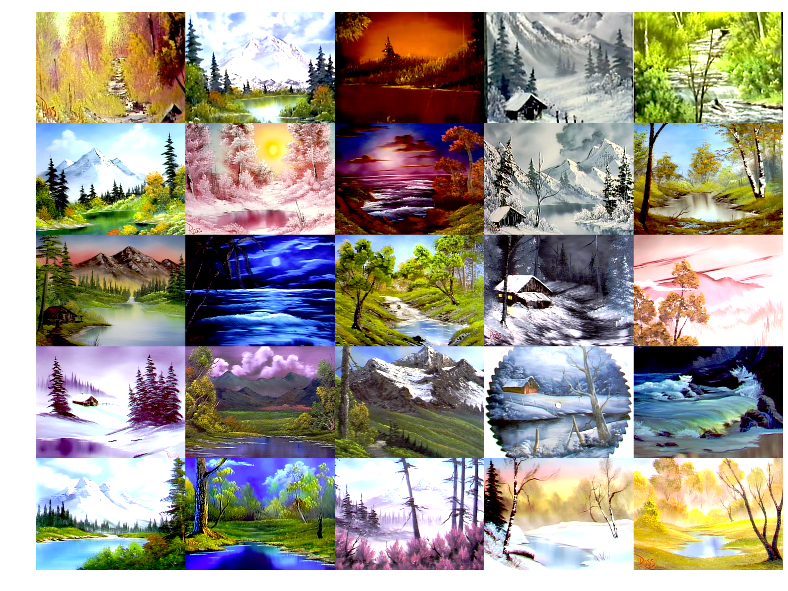

In [12]:
# show a selection of  of BOB ROSS TJOP images:
num_seasons  = 5 # number of season to show images from
num_episodes = 5 # number of images to show per season

fig = plt.figure(figsize=(20, 10))

hei, wid, channels = tjop_ross[0].shape
image_selection = tjop_ross.reshape(31, 13, hei, wid, channels)[:num_seasons, :num_episodes, :, :, :]
image_selection = image_selection.transpose(0, 2, 1, 3, 4).reshape(num_seasons * hei, num_episodes * wid, channels)

plt.imshow(image_selection)
plt.axis('off')
plt.show()